In [74]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

pd.options.display.float_format = '{:,.4f}'.format

# Inputs and Parameters
filename = 'StockAndOptionQuoteForABNB.csv'

In [75]:
# Black-Scholes European-Options Gamma
def calcGammaEx(S, K, vol, T, r, q, optType, OI):
    if T == 0 or vol == 0:
        return 0

    dp = (np.log(S/K) + (r - q + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    dm = dp - vol*np.sqrt(T) 

    if optType == 'call':
        gamma = np.exp(-q*T) * norm.pdf(dp) / (S * vol * np.sqrt(T))
        return OI * 100 * S * S * 0.01 * gamma 
    else: # Gamma is same for calls and puts. This is just to cross-check
        gamma = K * np.exp(-r*T) * norm.pdf(dm) / (S * S * vol * np.sqrt(T))
        return OI * 100 * S * S * 0.01 * gamma 

In [76]:
optionsFile = open(filename)
optionsFileData = optionsFile.readlines()
optionsFile.close()

#Get Spot
Spot_Price = float(optionsFileData[4].split(',')[0].replace("'", ""))
Name = optionsFileData[0].split(' ')[6]
#Get date
Date = optionsFileData[0].split(' ')[-2].replace("''","")



In [77]:
from datetime import datetime, timedelta

df = pd.read_csv(filename, delimiter = ',' , skiprows=11)

#df.drop(df.columns[[0, 1,-1,-2]], axis = 1, inplace = True)

df.drop(df.columns[[0, 1]], axis = 1, inplace = True)

x= ['Call_Delta','Call_Gamma','Call_Theta','Call_Vega','Call__OI','Call_Last','CALL LX','Call_IV','Call_BID',
              'Call_BX','Call_ASK','AX','Expiration_date','StrikePrice','Put Bid','Put BX','Put Ask','AX_PUT','Put_Delta',
              'Put_Gamma','Put_Theta','Put_Vega','Put__OI',
              'Put_Last', 'Put_LX', 'Put_IV']

#print(len(x))

df.columns =x
df = df[df.Call_Delta != "Delta"]


df = df.dropna()
df=df.replace('--', 0)
#df.drop(index=df[df['Call_Delta'] == 'Delta'].index, inplace=True)

#df.dropna(subset = ['Call_Delta'], inplace=True)
#df = df.replace(['--'],'0')
#d.set_option('display.max_columns', None)
#df
df

,Call_Delta,Call_Gamma,Call_Theta,Call_Vega,Call__OI,Call_Last,CALL LX,Call_IV,Call_BID,Call_BX,...,Put Ask,AX_PUT,Put_Delta,Put_Gamma,Put_Theta,Put_Vega,Put__OI,Put_Last,Put_LX,Put_IV
0,0.97,0,-0.21,0.01,0,0,,193.69%,46.4,Z,...,0.03,P,0,0,-0.01,0,257,0.02,X,120.49%
1,0.98,0,-0.1,0.01,0,0,,148.76%,41.55,Z,...,0.05,D,-0.01,0,-0.02,0,971,0.05,X,116.63%
2,0.99,0,-0.05,0.01,0,0,,114.10%,36.5,Z,...,0.1,Q,-0.01,0,-0.04,0,"1,927",0.1,X,110.07%
3,0.92,0.01,-0.38,0.03,0,0,,164.22%,32,Z,...,0.22,X,-0.02,0,-0.08,0.01,31,0.19,I,108.71%
4,0.94,0.01,-0.2,0.02,2,29.06,W,117.20%,27.05,Z,...,0.34,X,-0.04,0,-0.12,0.01,17,0.34,I,102.79%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,0.26,0,-0.02,0.64,328,11,N,48.49%,10.6,C,...,137.8,Z,-0.7,0,-0.02,0.57,2,124.68,I,45.18%
624,0.25,0,-0.02,0.62,80,11.97,C,48.99%,9.6,C,...,146.8,Z,-0.7,0,-0.02,0.56,1,96.95,M,45.71%
625,0.22,0,-0.02,0.58,62,11.78,W,47.31%,7.1,X,...,156.35,Z,-0.69,0,-0.02,0.56,0,130.8,C,47.92%
626,0.22,0,-0.02,0.57,282,8.5,Z,48.71%,7.9,C,...,165.1,X,-0.69,0,-0.02,0.55,1,146,Z,48.61%


In [78]:
df['StrikePrice'] = df['StrikePrice'].astype(float)
df['Call_IV'] = df['Call_IV'].str.rstrip('%').astype('float') / 100.0
df['Put_IV'] = df['Put_IV'].str.rstrip('%').astype('float') / 100.0
df['Call_Gamma'] = df['Call_Gamma'].astype(float)
df['Put_Gamma'] = df['Put_Gamma'].astype(float)
df['Call__OI'] = df['Call__OI'].str.replace(",","").astype('float')
df['Put__OI'] = df['Put__OI'].str.replace(",","").astype('float')
df['Expiration_date'] = pd.to_datetime(df['Expiration_date'])
date_time_obj = datetime.strptime(Date, '%m/%d/%y')


In [79]:
df['Call Gamma Exposure'] = df['Call_Gamma'] * 100 * Spot_Price
df['Put Gamma Exposure'] = df['Put_Gamma'] * 100 * Spot_Price
# To further convert into 'per 1% move' quantity, multiply by 1% of spotPrice
df['CallGEX'] = df['Call_Gamma'] * df['Call__OI'] * 100 * Spot_Price * Spot_Price * 0.01
df['PutGEX'] = df['Put_Gamma'] * df['Put__OI'] * 100 * Spot_Price * Spot_Price * 0.01 * -1
df['TotalGamma'] = (df.CallGEX + df.PutGEX) / 10**9
dfAgg = df.groupby(['StrikePrice']).sum()
strikes = dfAgg.index.values
dfAgg

,Call_Gamma,Call__OI,Call_IV,Put_Gamma,Put__OI,Put_IV,Call Gamma Exposure,Put Gamma Exposure,CallGEX,PutGEX,TotalGamma
StrikePrice,,,,,,,,,,,
65.0000,0.0000,194.0000,1.6661,0.0000,"4,181.0000",1.4363,0.0000,0.0000,0.0000,0.0000,0.0000
70.0000,0.0000,549.0000,1.5250,0.0000,"4,167.0000",1.4139,0.0000,0.0000,0.0000,0.0000,0.0000
75.0000,0.0000,158.0000,8.2705,0.0000,"9,117.0000",7.6564,0.0000,0.0000,0.0000,0.0000,0.0000
80.0000,0.0000,209.0000,8.8446,0.0000,"7,472.0000",8.0159,0.0000,0.0000,0.0000,0.0000,0.0000
85.0000,0.0000,120.0000,8.5394,0.0000,"3,805.0000",7.9407,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
280.0000,0.0000,"3,186.0000",3.2109,0.0000,82.0000,3.0683,0.0000,0.0000,0.0000,0.0000,0.0000
290.0000,0.0000,"2,517.0000",3.2762,0.0000,47.0000,4.2589,0.0000,0.0000,0.0000,0.0000,0.0000
300.0000,0.0000,"5,746.0000",3.3287,0.0000,74.0000,4.4846,0.0000,0.0000,0.0000,0.0000,0.0000


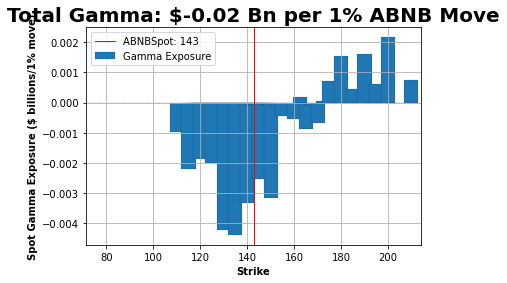

In [80]:
# To plot Gamma exposure 
#To limit it down to up and down 50%

from_strike = Spot_Price * 0.5
up_strike = Spot_Price * 1.5


plt.grid()
plt.bar(strikes, dfAgg['TotalGamma'].to_numpy(), width=6, linewidth=0.1, edgecolor='k', label="Gamma Exposure")
plt.xlim([from_strike, up_strike])
chartTitle = "Total Gamma: $" + str("{:.2f}".format(df['TotalGamma'].sum())) + " Bn per 1% " + Name + " Move"
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Strike', fontweight="bold")
plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=Spot_Price, color='r', lw=1, label= Name + "Spot: " + str("{:,.0f}".format(Spot_Price)))
plt.legend()



plt.show()

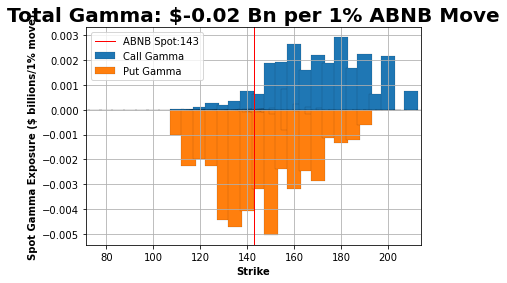

In [81]:
plt.grid()
plt.bar(strikes, dfAgg['CallGEX'].to_numpy() / 10**9, width=6, linewidth=0.1, edgecolor='k', label="Call Gamma")
plt.bar(strikes, dfAgg['PutGEX'].to_numpy() / 10**9, width=6, linewidth=0.1, edgecolor='k', label="Put Gamma")
plt.xlim([from_strike, up_strike])
chartTitle = "Total Gamma: $" + str("{:.2f}".format(df['TotalGamma'].sum())) + " Bn per 1% " +  Name + " Move"
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Strike', fontweight="bold")
plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=Spot_Price, color='r', lw=1, label=Name + " Spot:" + str("{:,.0f}".format(Spot_Price)))
plt.legend()
plt.show()

In [82]:
levels = np.linspace(from_strike, up_strike, 60)
df['day_to_expiry'] = df['Expiration_date'] - date_time_obj
df['day_to_expiry'] = df.apply(lambda row: row.day_to_expiry.days, axis=1)
df['day_to_expiry'] = df['day_to_expiry']/262

In [83]:
totalGamma = []

for level in levels:
    df['callGammaEx'] = df.apply(lambda row : calcGammaEx(level, row['StrikePrice'], row['Call_IV'], 
                                                          row['day_to_expiry'], 0, 0, "call", row['Call__OI']), axis = 1)

    df['putGammaEx'] = df.apply(lambda row : calcGammaEx(level, row['StrikePrice'], row['Put_IV'], 
                                                         row['day_to_expiry'], 0, 0, "put", row['Put__OI']), axis = 1)    

    totalGamma.append(df['callGammaEx'].sum() - df['putGammaEx'].sum())
    
totalGamma = np.array(totalGamma) / 10**9


In [84]:
zeroCrossIdx = np.where(np.diff(np.sign(totalGamma)))[0]

negGamma = totalGamma[zeroCrossIdx]
posGamma = totalGamma[zeroCrossIdx+1]
negStrike = levels[zeroCrossIdx]
posStrike = levels[zeroCrossIdx+1]

# Writing and sharing this code is only possible with your support! 
# If you find it useful, consider supporting us at perfiliev.com/support :)
zeroGamma = posStrike - ((posStrike - negStrike) * posGamma/(posGamma-negGamma))
zeroGamma = zeroGamma[0]

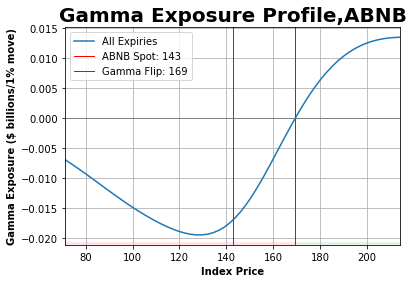

In [85]:
fig, ax = plt.subplots()
plt.grid()
plt.plot(levels, totalGamma, label="All Expiries")
#plt.plot(levels, totalGammaExNext, label="Ex-Next Expiry")
#plt.plot(levels, totalGammaExFri, label="Ex-Next Monthly Expiry")
chartTitle = "Gamma Exposure Profile," + Name
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Index Price', fontweight="bold")
plt.ylabel('Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=Spot_Price, color='r', lw=1, label= Name + " Spot: " + str("{:,.0f}".format(Spot_Price)))
plt.axvline(x=zeroGamma, color='g', lw=1, label="Gamma Flip: " + str("{:,.0f}".format(zeroGamma)))
plt.axhline(y=0, color='grey', lw=1)
plt.xlim([from_strike, up_strike])
trans = ax.get_xaxis_transform()
plt.fill_between([from_strike, zeroGamma], min(totalGamma), max(totalGamma), facecolor='red', alpha=0.1, transform=trans)
plt.fill_between([zeroGamma, up_strike], min(totalGamma), max(totalGamma), facecolor='green', alpha=0.1, transform=trans)
plt.legend()
plt.show()